In [385]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import itertools as it

from utilities.data_visualizers import view_value_frequency, describe_col, visualize_graph
from utilities.data_preprocessors import build_value_to_index, is_strictly_inc_by_k, normalize_ratings
from utilities.data_loaders import load_raw_ratings_large, load_raw_kg_20k



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [386]:
ml_1m_ratings = load_raw_ratings_large('./data/ml-1m')
ml_1m_ratings

d:\Projects\To Github\phil-jurisprudence-recsys\utilities\data_loaders.py:34: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  file = open(f'{dir_path}/ratings.dat', 'rb')


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


# userId column

In [387]:
describe_col(ml_1m_ratings, 'user_id')

count/no. of occurences of each unique user_id out of 1000209: 

total unique values: 6040


# itemId column

In [388]:
describe_col(ml_1m_ratings, 'item_id')

count/no. of occurences of each unique item_id out of 1000209: 

total unique values: 3706


# rating column

In [389]:
describe_col(ml_1m_ratings, 'rating')

count/no. of occurences of each unique rating out of 1000209: 

total unique values: 5


In [390]:
user_id_counts = ml_1m_ratings['user_id'].value_counts()
item_id_counts = ml_1m_ratings['item_id'].value_counts()
print(user_id_counts)
print(item_id_counts)

4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
        ... 
5725      20
3407      20
1664      20
4419      20
3021      20
Name: user_id, Length: 6040, dtype: int64
2858    3428
260     2991
1196    2990
1210    2883
480     2672
        ... 
3458       1
2226       1
1815       1
398        1
2909       1
Name: item_id, Length: 3706, dtype: int64


d:\Projects\To Github\phil-jurisprudence-recsys\utilities\data_visualizers.py:86: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data = value_counts.sort_values(ascending=True)[:limit]


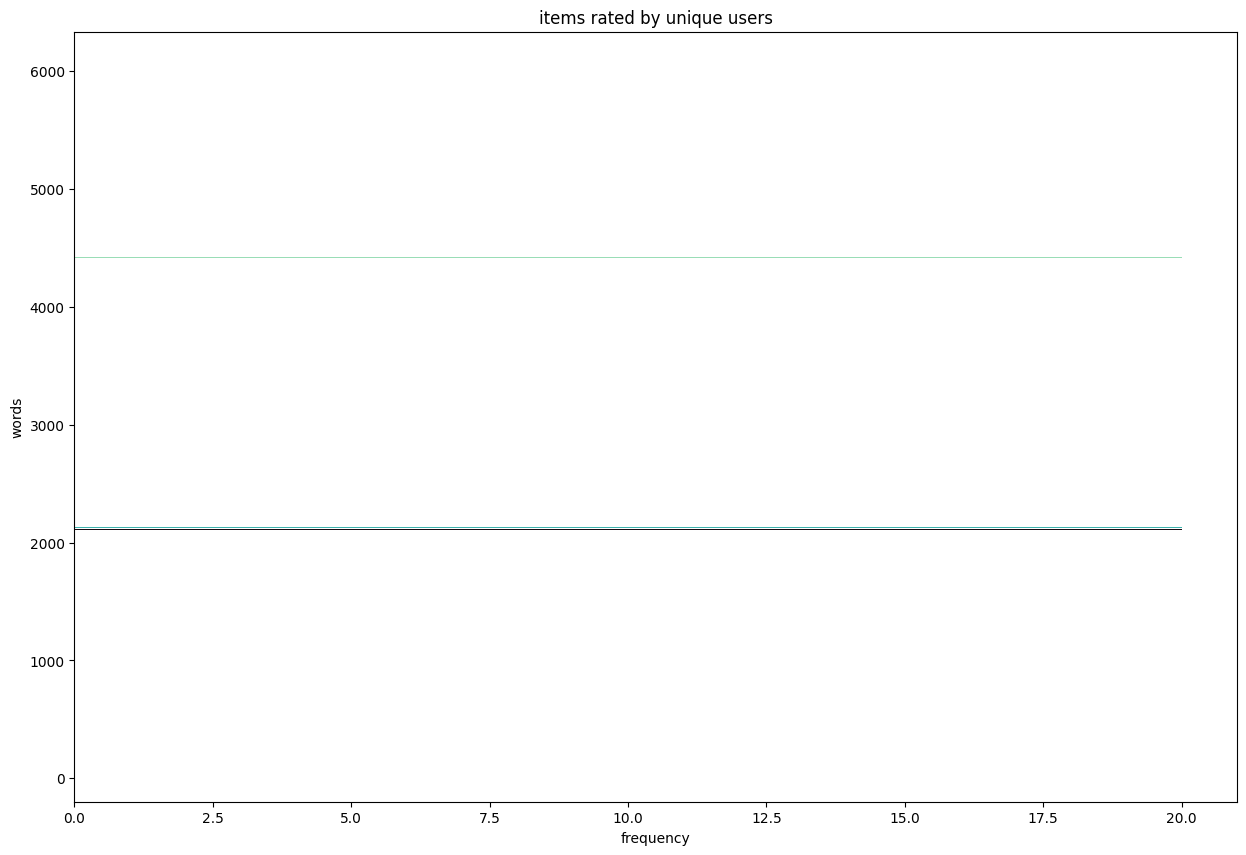

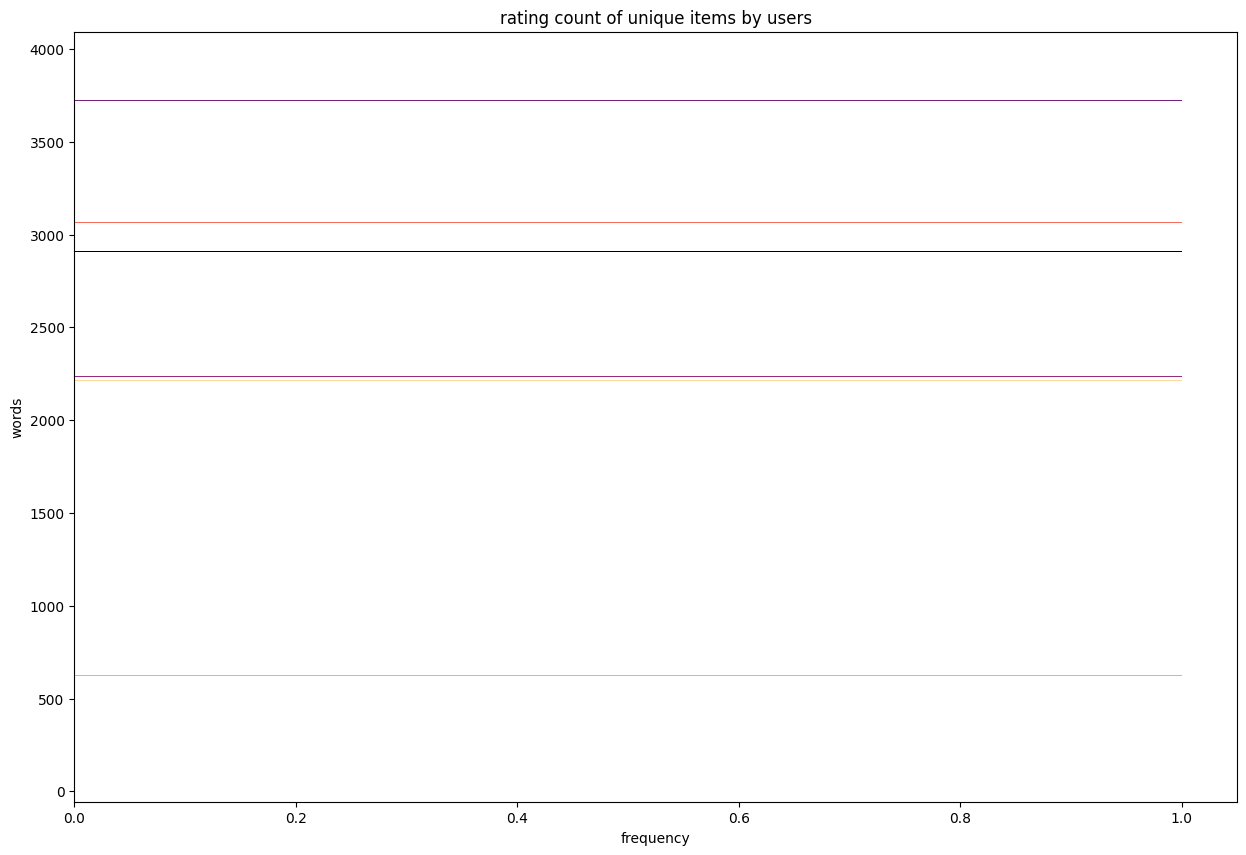

In [391]:
view_value_frequency(user_id_counts, colormap='mako', title='items rated by unique users', limit=50)
view_value_frequency(item_id_counts, colormap='magma', title='rating count of unique items by users', limit=50)

In [392]:
# get user_id unique values and sort them
unique_user_ids = ml_1m_ratings['user_id'].unique()
unique_user_ids.sort()

print(f"unique user id's: {unique_user_ids[:15]}")
print(f"do unique user id's have missing user id's? {is_strictly_inc_by_k(unique_user_ids, 1)}")

# get number of all unique users/user id's
n_users = unique_user_ids.shape[0]
print(f"number of unique users: {n_users}")

# build dictionary to map unique id's to new indeces
user_to_index = build_value_to_index(unique_user_ids)
sampled = dict(it.islice(user_to_index.items(), 15))
print(f"sampled dictionary of all unique users mapped to their respective indeces from 0 to |n_u - 1| {sampled}")

unique user id's: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
do unique user id's have missing user id's? False
number of unique users: 6040
sampled dictionary of all unique users mapped to their respective indeces from 0 to |n_u - 1| {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14}


In [393]:
# get item_id unique values and sort them
unique_item_ids = ml_1m_ratings['item_id'].unique()
unique_item_ids.sort()

print(f"unique item id's: {unique_item_ids[:15]}")
print(f"do unique item id's have missing item id's? {is_strictly_inc_by_k(unique_item_ids, 1)}")

# get number of all unique items/item id's
n_items = unique_item_ids.shape[0]
print(f"number of unique items: {n_items}")

# build dictionary to map unique id's to new indeces
item_to_index = build_value_to_index(unique_item_ids)
sampled = dict(it.islice(item_to_index.items(), 15))
print(f"sampled dictionary of all unique items mapped to their respective indeces from 0 to |n_u - 1| {sampled}")

unique item id's: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
do unique item id's have missing item id's? True
number of unique items: 3706
sampled dictionary of all unique items mapped to their respective indeces from 0 to |n_u - 1| {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14}


In [394]:
# modify dataframe column user_id with new indeces from 0 to n_u - 1
ml_1m_ratings['user_id'] = ml_1m_ratings['user_id'].apply(lambda user_id: user_to_index[user_id])
ml_1m_ratings['item_id'] = ml_1m_ratings['item_id'].apply(lambda item_id: item_to_index[item_id])

## testing initial models

In [395]:
import tensorflow as tf
from tensorflow.keras.regularizers import L2
# from tensorflow.keras.optimizers import Adam
from tensorflow.train.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError as mse_loss
from tensorflow.keras.metrics import MeanSquaredError as mse_metric
from tensorflow import GradientTape

## Define architecture of test model

In [396]:
# since length of user_id is only a scalar. Input would be None, 1 or m x 1
user_id_input = tf.keras.Input(shape=(1,), dtype=tf.int64, name='user_id')
item_id_input = tf.keras.Input(shape=(1,), dtype=tf.int64, name='item_id')

# user and item embedding layer would have embedding matrix of n_users x 32
# and n_items x 32 respectively in all training examples this would have 
# shape m x 1 x 32
user_emb_layer = tf.keras.layers.Embedding(n_users, 100, embeddings_regularizer=L2(0.9))
item_emb_layer = tf.keras.layers.Embedding(n_items, 100, embeddings_regularizer=L2(0.9))

# user and item embedding layer would have embedding matrix of n_users x 1
# the same as the learned bias vector BETA in matrix factorization
# in all training examples this would have m x 1 x 1
user_emb_bias_layer = tf.keras.layers.Embedding(n_users, 1, embeddings_initializer='zeros')
item_emb_bias_layer = tf.keras.layers.Embedding(n_items, 1, embeddings_initializer='zeros')

In [406]:
# forward pass
user_emb = user_emb_layer(user_id_input)
item_emb = item_emb_layer(item_id_input)

user_emb_bias = user_emb_bias_layer(user_id_input)
item_emb_bias = item_emb_bias_layer(item_id_input)
print(user_emb)
print(item_emb)

out = tf.linalg.matmul(user_emb, tf.transpose(item_emb, perm=[0, 2, 1])) + user_emb_bias + item_emb_bias

model = tf.keras.Model(inputs=[user_id_input, item_id_input], outputs=out)
model.summary()

model.compile(
    optimizer=Adam(learning_rate=0.003),
    loss=mse_loss(),
    metrics=[mse_metric()]
)

KerasTensor(type_spec=TensorSpec(shape=(None, 1, 32), dtype=tf.float32, name=None), name='embedding_8/embedding_lookup/Identity_1:0', description="created by layer 'embedding_8'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 32), dtype=tf.float32, name=None), name='embedding_9/embedding_lookup/Identity_1:0', description="created by layer 'embedding_9'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_9 (Embedding)     

In [ ]:
# implement here the mean normalizer function for the 
# ratigns then restore it after prediciton
# note: we use Y_normed in training and 

# Insights:
1. In 1m rows of ratings there are 6040 unique users
2. In 1m rows of ratings there are 3706 unique items that were rated

# Knowledge Graph/Network analysis

In [398]:
# 20782 rows
kg = load_raw_kg_20k('./data/ml1m-kg20k/')
kg

,head,relation,tail
0,749,film.film.writer,2347
1,1410,film.film.language,2348
2,1037,film.film.language,2348
3,1088,film.film.writer,2349
4,1391,film.film.language,2348
...,...,...,...
20777,2308,film.film.writer,4284
20778,869,film.film.language,2348
20779,1953,film.film.genre,2362
20780,2705,film.film.director,5417


In [399]:
describe_col(kg, 'head')

count/no. of occurences of each unique head out of 20782: 

total unique values: 2445


count/no. of occurences of each unique relation out of 20782: 

total unique values: 7


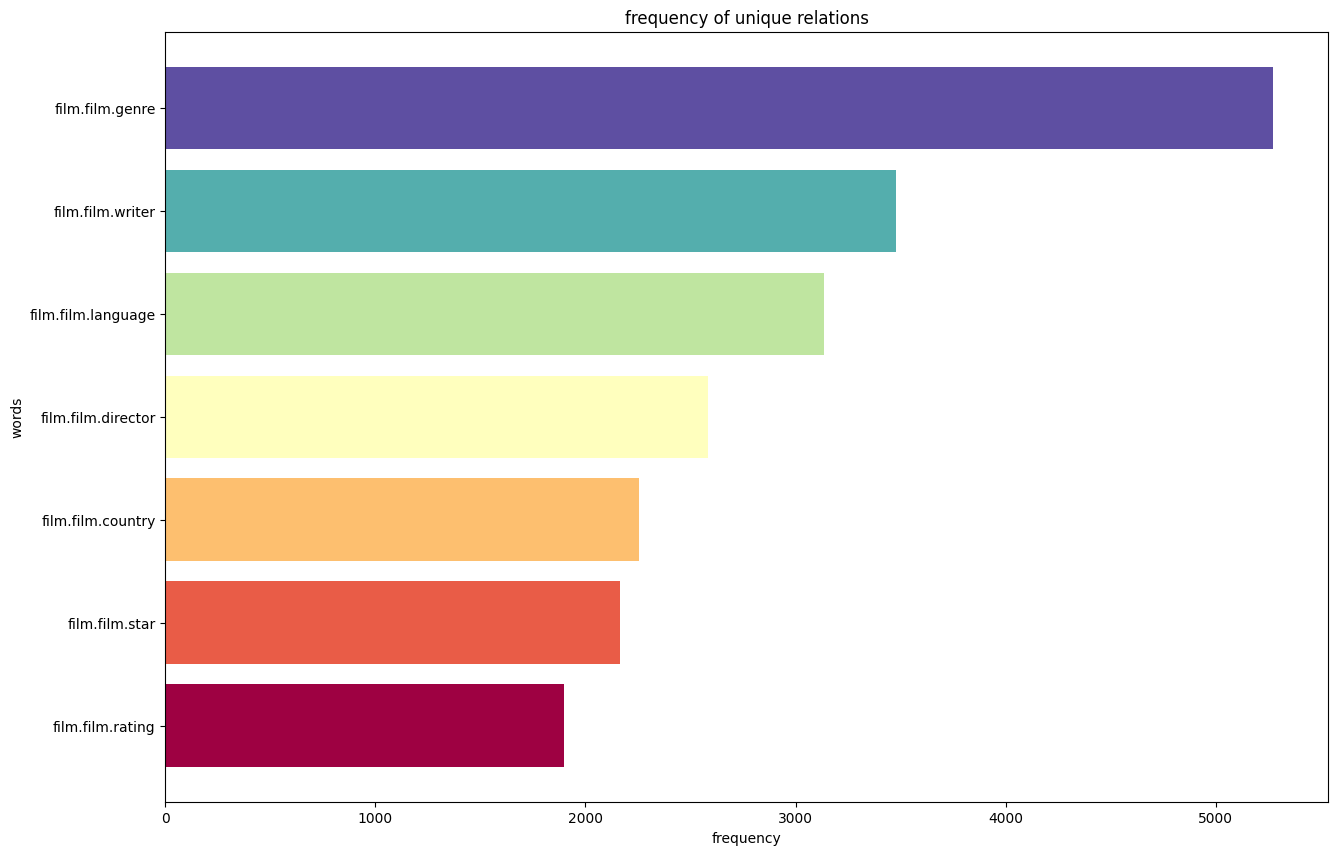

In [400]:
describe_col(kg, 'relation')

relations_count = kg['relation'].value_counts()
view_value_frequency(relations_count, colormap='Spectral', title='frequency of unique relations', limit=relations_count.shape[0])

In [401]:
describe_col(kg, 'tail')

count/no. of occurences of each unique tail out of 20782: 

total unique values: 4563


# Analyze what nodes are connected to who

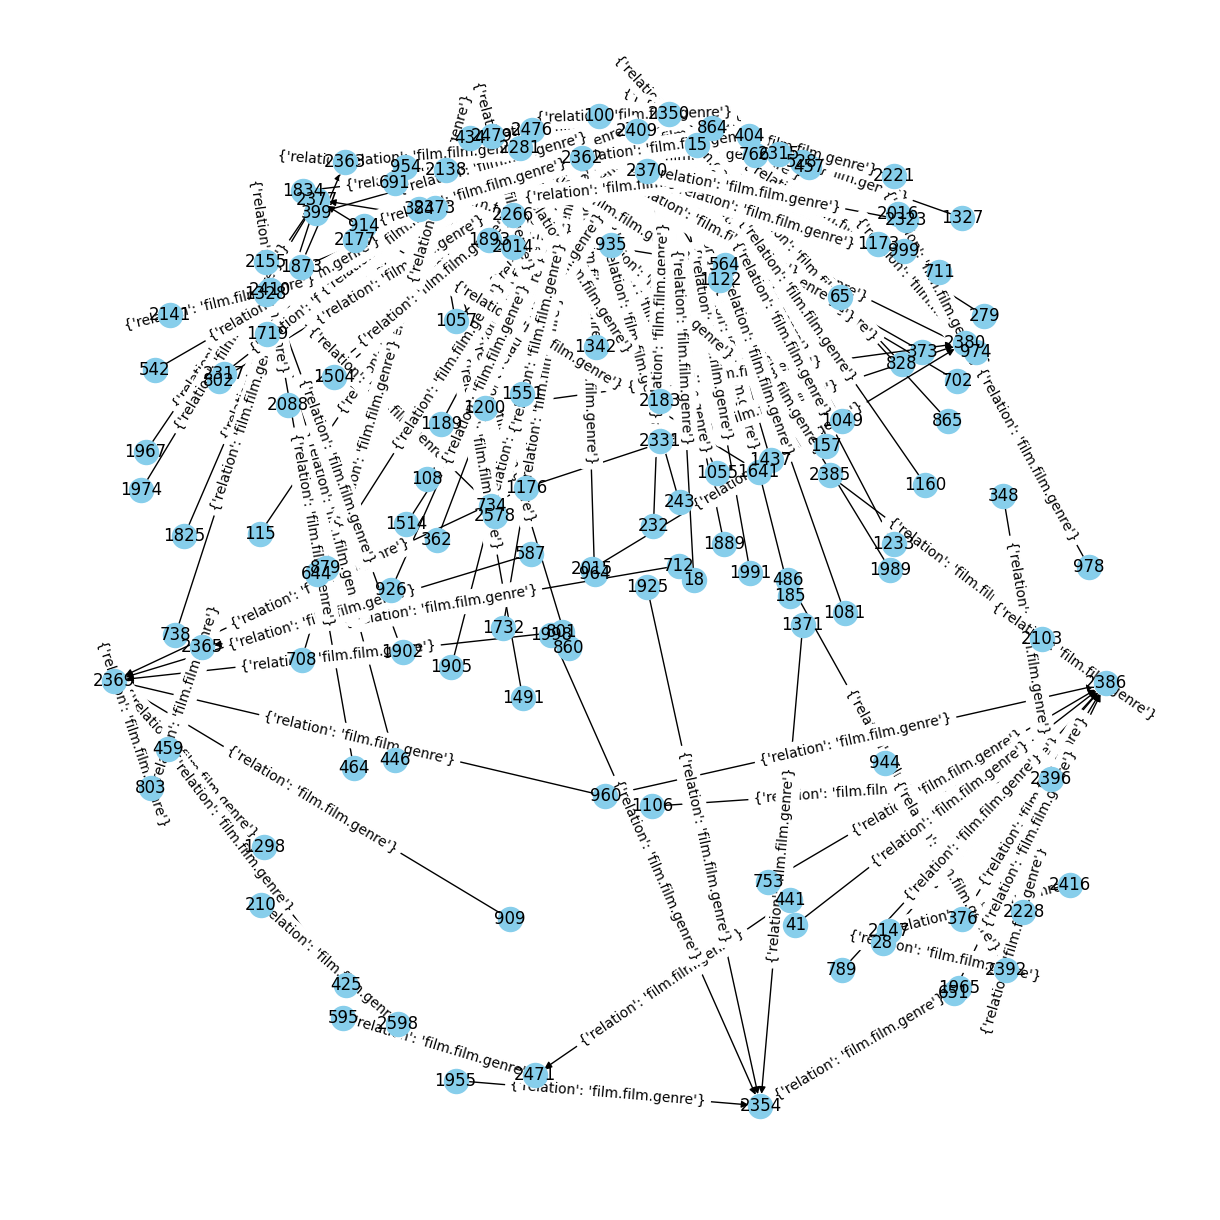

In [402]:
visualize_graph(kg)

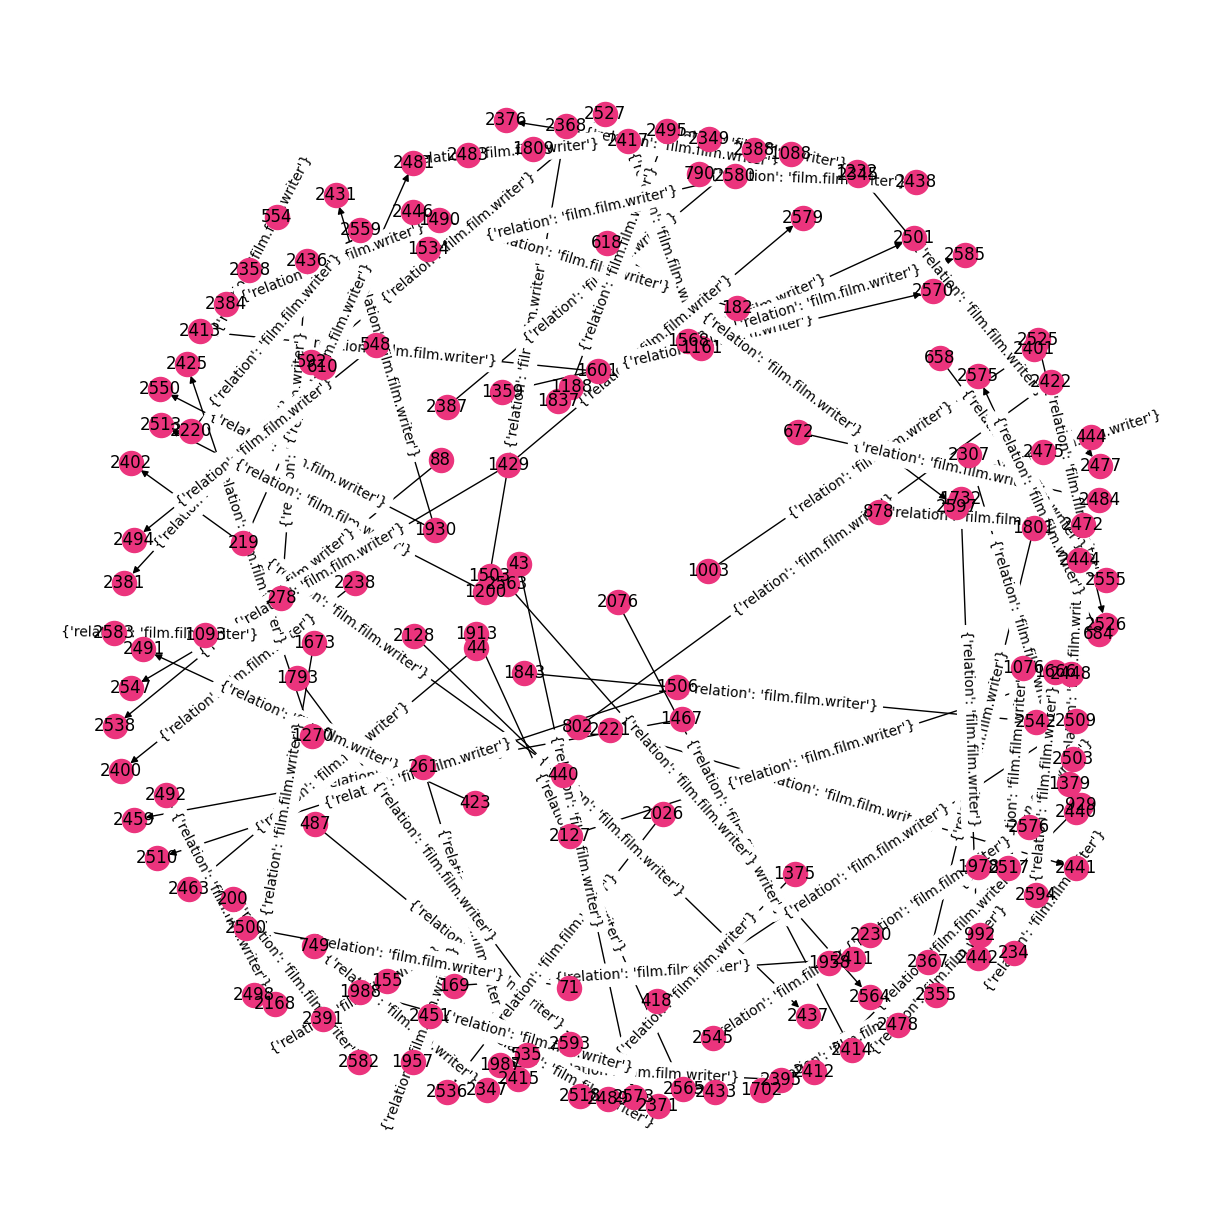

In [403]:
visualize_graph(kg, edge='film.film.writer', node_color='#eb347d')

# Does the head and tail entities appear as an item in the user item interaction data?